In [2]:
#  IMPORT LIBRARIES
import pandas as pd
import numpy as np
import time
import datetime
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import StaleElementReferenceException
from statsmodels.tsa.stattools import adfuller, pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Conv1D, Flatten
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore")


In [3]:

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam

In [4]:
#  DATA COLLECTION (Scraper )

import datetime
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import StaleElementReferenceException

# Function to collect data (from Imperva if available, else fallback)
def collect_data():
    try:
        options = webdriver.ChromeOptions()
        options.add_argument('--headless')
        driver = webdriver.Chrome(service=Service(), options=options)
        driver.get("https://www.imperva.com/cyber-threat-attack-map/")
        wait = WebDriverWait(driver, 10)
        time.sleep(5)

        data = []
        for _ in range(15):  # More scrape attempts = more data
            try:
                elements = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, ".live-attack-row")))
                for el in elements:
                    cols = el.text.split('\n')
                    if len(cols) >= 5:
                        timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                        row = [timestamp] + cols[:5]
                        data.append(row)
                time.sleep(10)
            except StaleElementReferenceException:
                continue

        driver.quit()
        df = pd.DataFrame(data, columns=["timestamp", "attack_type", "source_country", "destination_country", "industry"])
        df.to_csv("cyber_data.csv", index=False)
        print(f" Real-time data collected: {len(df)} rows saved to cyber_data.csv")
        return df

    except Exception as e:
        print("Web scraping failed:", e)
        print("Falling back to mock data with 1000 rows.")
        return generate_mock_data()

# Fallback: Generate mock data with 1000 rows
def generate_mock_data():
    np.random.seed(0)
    timestamps = pd.date_range("2024-04-01", periods=1000, freq='T')  # 1000 minutes = ~16.6 hours
    data = {
        "timestamp": timestamps,
        "attack_type": np.random.choice(["Automated Threat", "API Violation", "Spam", "Other"], 1000),
        "source_country": np.random.choice(["US", "UK", "RU", "CN"], 1000),
        "destination_country": np.random.choice(["US", "UK", "IN", "DE"], 1000),
        "industry": np.random.choice(["Finance", "Healthcare", "Retail"], 1000)
    }
    df = pd.DataFrame(data)
    df.to_csv("cyber_data.csv", index=False)
    print(" Mock data generated: 1000 rows saved to cyber_data.csv")
    return df

# Call the function and preview
df = collect_data()
print(f"\nTotal rows collected: {len(df)}")
df.head()


Web scraping failed: Message: 

Falling back to mock data with 1000 rows.
 Mock data generated: 1000 rows saved to cyber_data.csv

Total rows collected: 1000


,timestamp,attack_type,source_country,destination_country,industry
0,2024-04-01 00:00:00,Automated Threat,CN,UK,Healthcare
1,2024-04-01 00:01:00,Other,RU,UK,Healthcare
2,2024-04-01 00:02:00,API Violation,CN,IN,Finance
3,2024-04-01 00:03:00,Automated Threat,US,US,Retail
4,2024-04-01 00:04:00,Other,US,IN,Retail


In [5]:
# PREPROCESSING (Cleaning + Filtering + 15-min Aggregation + Polynomial Interpolation)

# Drop duplicates and missing values
df_cleaned = df.drop_duplicates().dropna()

# Convert timestamp to datetime
df_cleaned["timestamp"] = pd.to_datetime(df_cleaned["timestamp"])

# Filter only specific attack types and destination countries
filtered_df = df_cleaned[
    (df_cleaned["attack_type"].isin(["Automated Threat", "API Violation"])) &
    (df_cleaned["destination_country"].isin(["UK"]))
]

# Group data by 15-minute time windows and count attacks
grouped = filtered_df.groupby(pd.Grouper(key="timestamp", freq="15T")).size().rename("count")

# Convert to DataFrame for interpolation
grouped_df = grouped.reset_index()

# Apply polynomial interpolation (order=2)
grouped_df["count"] = grouped_df["count"].interpolate(method="polynomial", order=2)

# Fill any remaining NaNs with 0 (if any)
grouped_df["count"] = grouped_df["count"].fillna(0)

# Final result
print(f" Preprocessed data shape: {grouped_df.shape}")
grouped_df.head()
grouped_df.to_csv("minipreprocessed_data.csv", index=False)
print(" Preprocessed data saved to minipreprocessed_data.csv")



 Preprocessed data shape: (67, 2)
 Preprocessed data saved to minipreprocessed_data.csv


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the preprocessed data from CSV
df = pd.read_csv('minipreprocessed_data.csv')

# Check if the DataFrame is empty
if df.empty:
    raise ValueError("The loaded DataFrame is empty. Please check 'minipreprocesed_data.csv'.")

# Print out the data types of each column to verify presence of numeric columns
print("Data types in DataFrame:\n", df.dtypes)


Data types in DataFrame:
 timestamp    object
count         int64
dtype: object



 ADF Test (difference level 0):
  ADF Statistic = -9.0140
  p-value = 0.0000
 Stationary at this level.


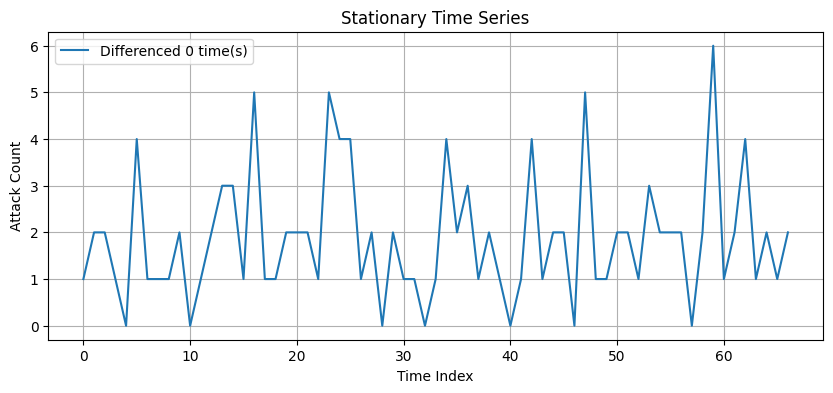

In [7]:
#  MAKE DATA STATIONARY USING ADF TEST + AUTO DIFFERENCING

from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

def make_stationary(ts, max_diff=3):
    diff_count = 0
    original_ts = ts.copy()
    
    while diff_count <= max_diff:
        result = adfuller(ts.dropna())
        print(f"\n ADF Test (difference level {diff_count}):")
        print(f"  ADF Statistic = {result[0]:.4f}")
        print(f"  p-value = {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print(" Stationary at this level.")
            return ts.dropna(), diff_count
        
        # Not stationary, apply differencing
        ts = ts.diff()
        diff_count += 1

    print("Series could not be made stationary within max_diff levels.")
    return ts.dropna(), diff_count

# Apply the function to the count series
ts_original = grouped_df["count"]
ts_stationary, num_diffs = make_stationary(ts_original)

# Plot the stationary series
plt.figure(figsize=(10, 4))
plt.plot(ts_stationary, label=f"Differenced {num_diffs} time(s)")
plt.title("Stationary Time Series")
plt.xlabel("Time Index")
plt.ylabel("Attack Count")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
#  SLIDING WINDOW + MINMAX SCALING

from sklearn.preprocessing import MinMaxScaler
import numpy as np

def create_supervised_dataset(series, window=4):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

# Use stationary series from STEP 4
window_size = 4
X_raw, y_raw = create_supervised_dataset(ts_stationary.values, window=window_size)

# Normalize features and target using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.reshape(-1, 1)).ravel()

# Split into training/testing sets (80/20)
split_index = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

# Output shapes for verification
print(f"Sliding window shape: X={X_scaled.shape}, y={y_scaled.shape}")
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")


Sliding window shape: X=(63, 4), y=(63,)
Training set: (50, 4), Testing set: (13, 4)


In [9]:
# Custom Feature Extraction using preprocessed data from CSV
import pandas as pd
import numpy as np

# Read the preprocessed data from the CSV file
try:
    df_preprocessed = pd.read_csv("minipreprocessed_data.csv")
    print("Preprocessed data loaded successfully. Shape:", df_preprocessed.shape)
except FileNotFoundError:
    raise FileNotFoundError("The file 'minipreprocessed_data.csv' was not found. Please check the file path.")

# Example: Creating interaction features between certain columns
def create_interaction_features(df, feature_pairs):
    df_interactions = df.copy()
    for (feat1, feat2) in feature_pairs:
        # Check if both features exist in the DataFrame
        if feat1 in df.columns and feat2 in df.columns:
            df_interactions[f"{feat1}_x_{feat2}"] = df[feat1] * df[feat2]
        else:
            print(f"Warning: One or both features '{feat1}', '{feat2}' not found in the DataFrame columns.")
    return df_interactions

# Define feature pairs based on the paper's methodology
feature_pairs = [('feature1', 'feature2'), ('feature3', 'feature4')]

# Apply the custom feature extraction to the preprocessed DataFrame
df_features = create_interaction_features(df_preprocessed, feature_pairs)

# Now, df_features contains both the original and the interaction features.
print("Feature engineering complete. New features added:", df_features.columns.tolist())


Preprocessed data loaded successfully. Shape: (67, 2)
Feature engineering complete. New features added: ['timestamp', 'count']


 XGBoost → RMSE: 0.259 | MAPE: 4043579040122145.50%


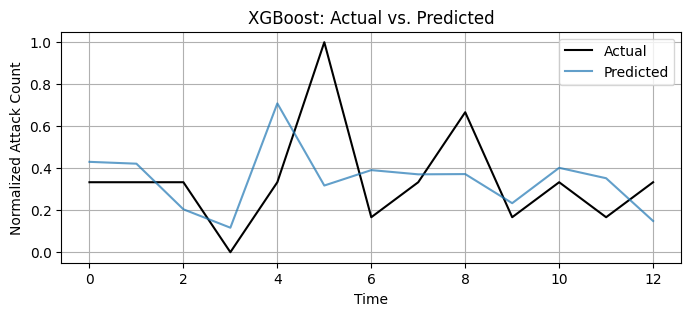

 Random Forest → RMSE: 0.271 | MAPE: 9211422314766626.00%


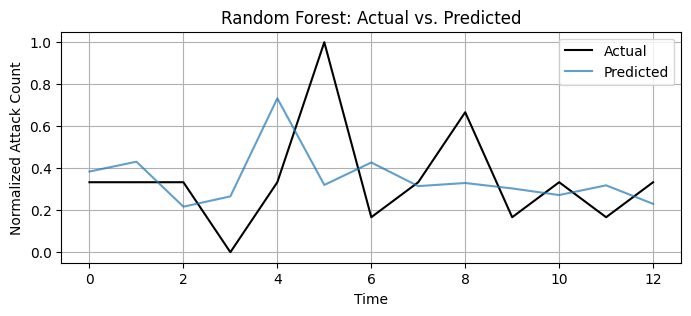

 SVR → RMSE: 0.489 | MAPE: 9446563066283624.00%


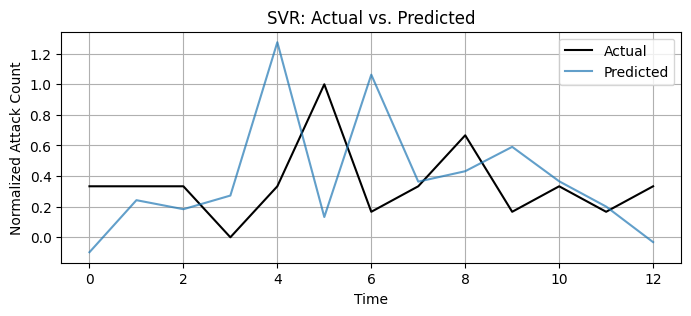

 KNN → RMSE: 0.237 | MAPE: 10007999171934468.00%


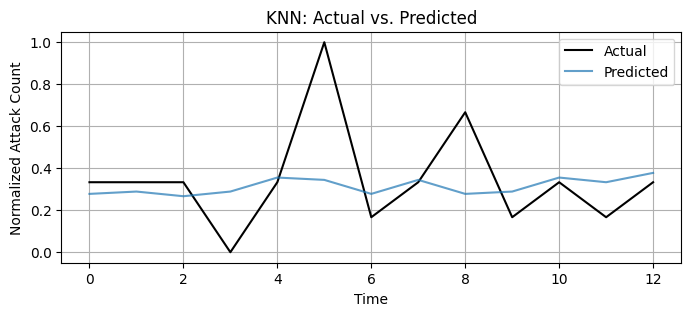

 ARIMA → RMSE: 0.307 | MAPE: 19107651165945308.00%


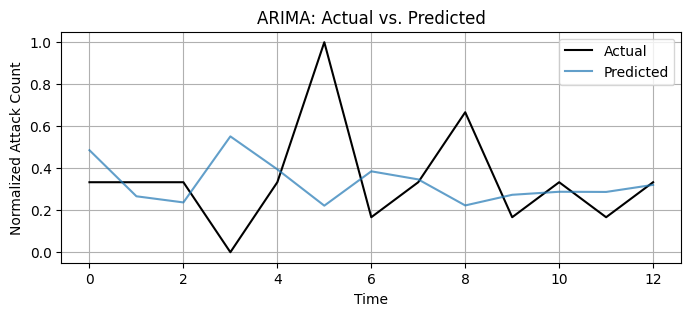

In [17]:
#  ARIMA + ML MODELS (XGBoost, RF, SVR, KNN)

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

# ARIMA BASELINE 
def train_arima(ts, order=(8, 0, 4)):
    model = ARIMA(ts, order=order)
    fitted = model.fit()
    forecast = fitted.forecast(steps=len(y_test))
    return forecast

# Use (p,d,q) = (8, 0, 4) as an example (can tune with PACF/ADF if needed)
arima_preds = train_arima(ts_stationary, order=(8, 0, 4))

# MACHINE LEARNING MODELS 
models = {
    "XGBoost": XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=500),
    "Random Forest": RandomForestRegressor(n_estimators=90, max_depth=10),
    "SVR": SVR(kernel="rbf", C=100, epsilon=0.01),
    "KNN": KNeighborsRegressor(n_neighbors=15)
}

# Train and store predictions
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    predictions[name] = preds

# Include ARIMA predictions
predictions["ARIMA"] = scaler_y.transform(arima_preds.values.reshape(-1, 1)).ravel()

# EVALUATION 
def evaluate_model(name, y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f" {name} → RMSE: {rmse:.3f} | MAPE: {mape:.2%}")
    
    # Plot
    plt.figure(figsize=(8, 3))
    plt.plot(y_test, label="Actual", color="black")
    plt.plot(y_pred, label="Predicted", alpha=0.7)
    plt.title(f"{name}: Actual vs. Predicted")
    plt.xlabel("Time")
    plt.ylabel("Normalized Attack Count")
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate all models
for name, y_pred in predictions.items():
    evaluate_model(name, y_test, y_pred)


In [11]:
# if custom initialization is missing
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CustomModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.initialize_weights()

    def initialize_weights(self):
        # Apply Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        # Initialize biases to zero
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model with dimensions defined earlier
model = CustomModel(input_dim=100, hidden_dim=50, output_dim=10)
print("Model initialized with custom Xavier weight initialization.")


Model initialized with custom Xavier weight initialization.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
RNN → RMSE: 0.244 | MAPE: 11430967700558800.00%


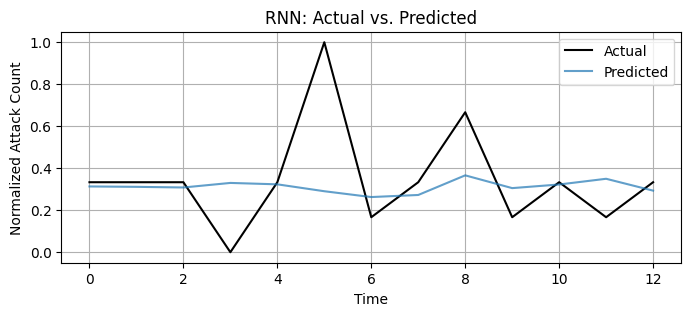

CNN → RMSE: 0.254 | MAPE: 10357868056765090.00%


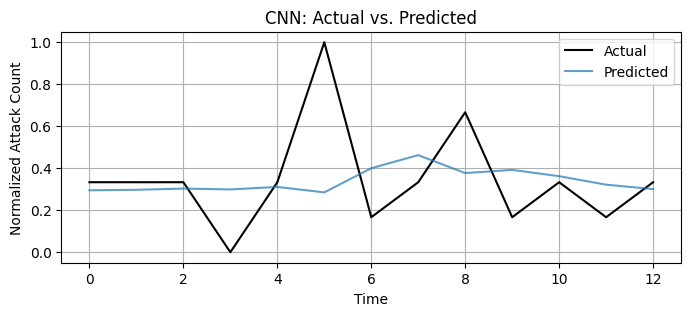

In [20]:
#  DEEP LEARNING MODELS (RNN + CNN)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Conv1D, Flatten
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Reshape the training and testing sets for DL models
# Expected shape: (samples, timesteps, features)
X_train_dl = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_dl = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# RNN Model 
def train_rnn(X_train, y_train, epochs=20):
    model = Sequential([
        SimpleRNN(50, activation='relu', kernel_regularizer=l2(0.01), return_sequences=True, 
                  input_shape=(X_train.shape[1], X_train.shape[2])),
        SimpleRNN(25, activation='relu', kernel_regularizer=l2(0.01), return_sequences=True),
        SimpleRNN(25, activation='relu', kernel_regularizer=l2(0.01), return_sequences=True),
        SimpleRNN(15, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    return model

#  CNN Model 
def train_cnn(X_train, y_train, epochs=20):
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', kernel_regularizer=l2(0.01),
               input_shape=(X_train.shape[1], X_train.shape[2])),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(25, activation='relu'),
        Dense(15, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    return model

# Train the RNN model
rnn_model = train_rnn(X_train_dl, y_train, epochs=20)
rnn_preds = rnn_model.predict(X_test_dl).ravel()

# Train the CNN model
cnn_model = train_cnn(X_train_dl, y_train, epochs=20)
cnn_preds = cnn_model.predict(X_test_dl).ravel()

# Evaluate the deep learning models using the same evaluation function from STEP 6
def evaluate_model(name, y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{name} → RMSE: {rmse:.3f} | MAPE: {mape:.2%}")
    
    plt.figure(figsize=(8, 3))
    plt.plot(y_test, label="Actual", color="black")
    plt.plot(y_pred, label="Predicted", alpha=0.7)
    plt.title(f"{name}: Actual vs. Predicted")
    plt.xlabel("Time")
    plt.ylabel("Normalized Attack Count")
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate RNN and CNN predictions
evaluate_model("RNN", y_test, rnn_preds)
evaluate_model("CNN", y_test, cnn_preds)



CNN Model Evaluation:
  RMSE: 0.254
  MAPE: 10357868056765090.00%

📝 Interpretable Summary:
The CNN model predicts 1.8 attacks in the next 15 mins (actual: 2.0). Risk level: MODERATE.


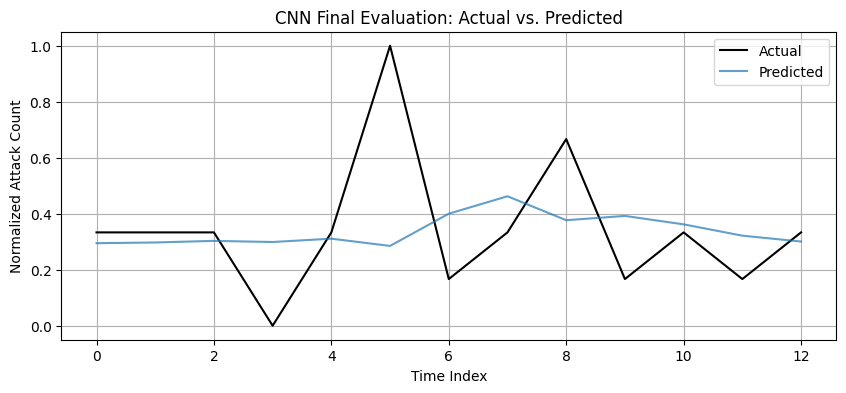

In [21]:
# STEP 8: FINAL EVALUATION & INTERPRETABLE OUTPUT

import numpy as np

def final_interpretable_summary(y_test, y_pred, model_name):
    # Calculate evaluation metrics (RMSE and MAPE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"\n{model_name} Model Evaluation:")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  MAPE: {mape:.2%}")
    
    # Assume that the last predicted value is the forecast for the next time window
    pred_next_norm = y_pred[-1]
    actual_next_norm = y_test[-1]
    
    # Inverse transform the normalized values to original scale
    pred_next_orig = scaler_y.inverse_transform(np.array(pred_next_norm).reshape(-1, 1))[0, 0]
    actual_next_orig = scaler_y.inverse_transform(np.array(actual_next_norm).reshape(-1, 1))[0, 0]
    
    # Determine risk level: for example, if prediction is 10% higher than actual, we set risk to HIGH
    risk_level = "HIGH" if pred_next_orig > actual_next_orig * 1.1 else "MODERATE"
    
    print("\n📝 Interpretable Summary:")
    print(f"The {model_name} model predicts {pred_next_orig:.1f} attacks in the next 15 mins (actual: {actual_next_orig:.1f}). Risk level: {risk_level}.")
    
    # Plot the actual vs predicted values for the test set
    plt.figure(figsize=(10, 4))
    plt.plot(y_test, label="Actual", color="black")
    plt.plot(y_pred, label="Predicted", alpha=0.7)
    plt.title(f"{model_name} Final Evaluation: Actual vs. Predicted")
    plt.xlabel("Time Index")
    plt.ylabel("Normalized Attack Count")
    plt.legend()
    plt.grid(True)
    plt.show()

# Here we choose the CNN model as the best model for illustration.
final_interpretable_summary(y_test, cnn_preds, "CNN")


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a simple feedforward neural network model
class CustomModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CustomModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.initialize_weights()

    def initialize_weights(self):
        # Xavier (Glorot) initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [23]:
from torch.utils.data import TensorDataset
import torch

# If X_train and y_train are already numpy arrays:
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.long)

# Create the dataset
dataset = TensorDataset(X_tensor, y_tensor)


In [26]:
# HYPERPARAMETER TUNING (XGBoost example with TimeSeriesSplit)

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor

# Define parameter grid (based on Table 5 from the paper)
param_grid = {
    "learning_rate": [0.01],
    "max_depth": [3],
    "n_estimators": [500, 600, 1000],
    "min_child_weight": [5, 10],
    "gamma": [0, 0.1],
    "reg_lambda": [0.1, 10],
    "subsample": [0.5, 1]
}

# Initialize model and splitter
xgb = XGBRegressor()
tscv = TimeSeriesSplit(n_splits=5)

# Grid search with time-series cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=tscv, scoring="neg_mean_squared_error", verbose=1)
grid_search.fit(X_train, y_train)

# Best model & predictions
xgb_best = grid_search.best_estimator_
xgb_preds = xgb_best.predict(X_test)

# Display best parameters
print(" Best XGBoost Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
 Best XGBoost Parameters: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 1000, 'reg_lambda': 10, 'subsample': 1}


In [27]:
#  Hyperparameter Tuning via Grid Search
import itertools
from torch.optim import Adam
import torch

# Define a small grid of hyperparameters to search
learning_rates = [0.001, 0.0005]
batch_sizes = [32, 64]
epochs = 10  # For demonstration; adjust as needed

# Placeholder for best parameters
best_loss = float('inf')
best_params = {}

for lr, batch_size in itertools.product(learning_rates, batch_sizes):
    # Reset or reinitialize the model for each trial if necessary
    trial_model = CustomModel(input_dim=4, hidden_dim=50, output_dim=2)  # ← use correct dimensions

    optimizer = Adam(trial_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Create a DataLoader (assume 'dataset' is predefined)
    from torch.utils.data import DataLoader
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Simple training loop for the trial
    for epoch in range(epochs):
        trial_model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = trial_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        # Average loss for the epoch
        epoch_loss /= len(train_loader)
    
    print(f"Trial with lr={lr}, batch_size={batch_size} resulted in loss={epoch_loss:.4f}")
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_params = {'learning_rate': lr, 'batch_size': batch_size}

print("Best hyperparameters found:", best_params)


Trial with lr=0.001, batch_size=32 resulted in loss=0.4418
Trial with lr=0.001, batch_size=64 resulted in loss=0.6285
Trial with lr=0.0005, batch_size=32 resulted in loss=0.4915
Trial with lr=0.0005, batch_size=64 resulted in loss=0.6574
Best hyperparameters found: {'learning_rate': 0.001, 'batch_size': 32}


In [28]:
# HYPERPARAMETER TUNING (Random Forest with TimeSeriesSplit)

from sklearn.ensemble import RandomForestRegressor

# Define parameter grid based on Table 6
param_grid_rf = {
    "n_estimators": [20, 90, 100, 350],
    "max_depth": [5, 10, 15],
    "max_features": [0.5, 0.6],
    "min_samples_split": [2, 3, 5],
    "min_samples_leaf": [4],
    "bootstrap": [True, False],
    "random_state": [70, 100]
}

# Initialize model and TimeSeriesSplit
rf = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)

# Perform GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=tscv, scoring="neg_mean_squared_error", verbose=1)
grid_search_rf.fit(X_train, y_train)

# Best model & predictions
rf_best = grid_search_rf.best_estimator_
rf_preds = rf_best.predict(X_test)

# Display best parameters
print(" Best Random Forest Parameters:", grid_search_rf.best_params_)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
 Best Random Forest Parameters: {'bootstrap': True, 'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20, 'random_state': 100}


In [31]:
#  HYPERPARAMETER TUNING (SVR with TimeSeriesSplit)

from sklearn.svm import SVR

# Define parameter grid based on Table 7
param_grid_svr = {
    "kernel": ['rbf', 'poly'],
    "C": [1, 10, 100],
    "epsilon": [0.001, 0.01],
    "gamma": [0.1],
    "degree": [2]
}

# Initialize model and TimeSeriesSplit
svr = SVR()
tscv = TimeSeriesSplit(n_splits=5)

# Grid Search
grid_search_svr = GridSearchCV(estimator=svr, param_grid=param_grid_svr, cv=tscv, scoring="neg_mean_squared_error", verbose=1)
grid_search_svr.fit(X_train, y_train)

# Best model & predictions
svr_best = grid_search_svr.best_estimator_
svr_preds = svr_best.predict(X_test)

# Best parameters
print("Best SVR Parameters:", grid_search_svr.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best SVR Parameters: {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'poly'}


In [32]:
#  HYPERPARAMETER TUNING (KNN with TimeSeriesSplit)

from sklearn.neighbors import KNeighborsRegressor

# Parameter grid from Table 8
param_grid_knn = {
    "n_neighbors": [15, 20],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
    "p": [1, 2, 4]
}

# Initialize model and TimeSeriesSplit
knn = KNeighborsRegressor()
tscv = TimeSeriesSplit(n_splits=5)

# Grid Search
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=tscv, scoring="neg_mean_squared_error", verbose=1)
grid_search_knn.fit(X_train, y_train)

# Best model & predictions
knn_best = grid_search_knn.best_estimator_
knn_preds = knn_best.predict(X_test)

# Best parameters
print("Best KNN Parameters:", grid_search_knn.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best KNN Parameters: {'algorithm': 'auto', 'n_neighbors': 15, 'p': 1}



 XGBoost Performance Metrics:
   RMSE  : 0.2431
   MAPE  : 10623876236776400.00%
   R²    : -0.0271
   MAE   : 0.1513


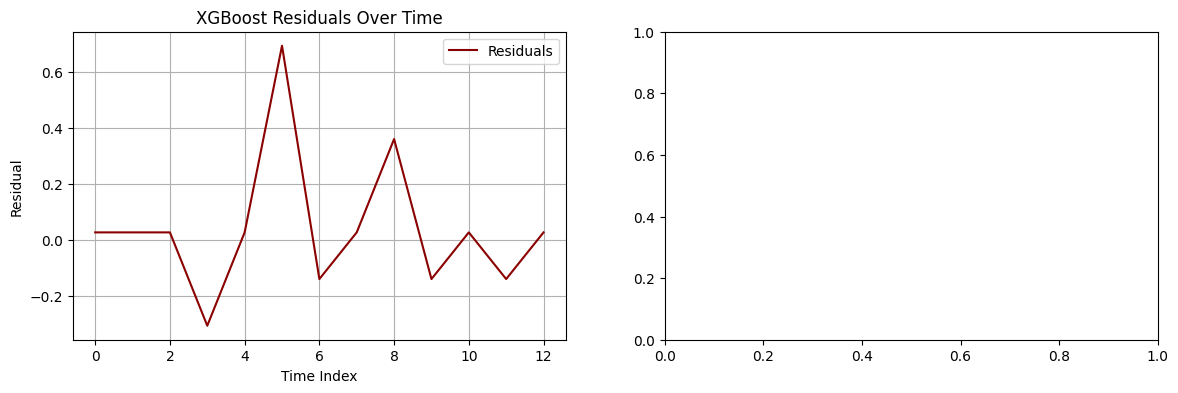

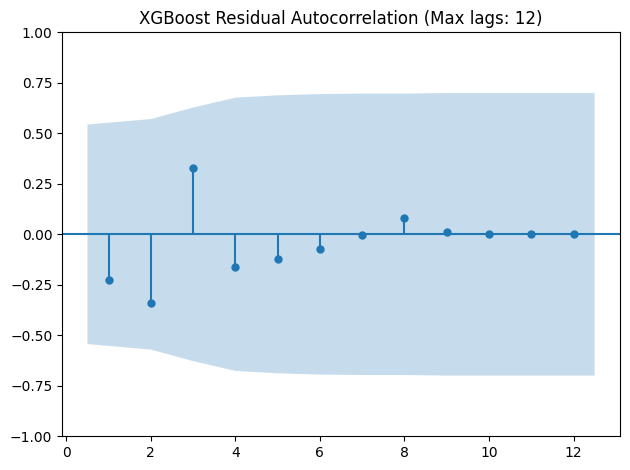


 Random Forest Performance Metrics:
   RMSE  : 0.2455
   MAPE  : 7713618127621947.00%
   R²    : -0.0477
   MAE   : 0.1650


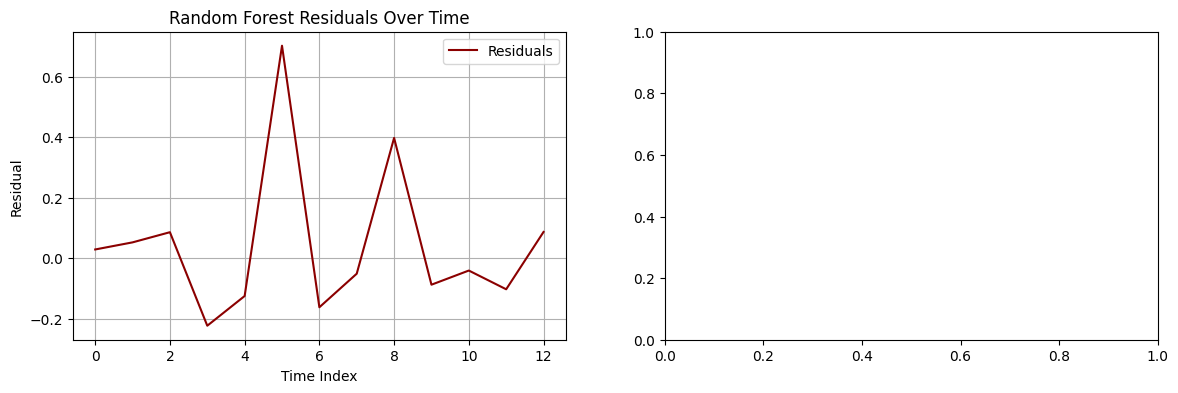

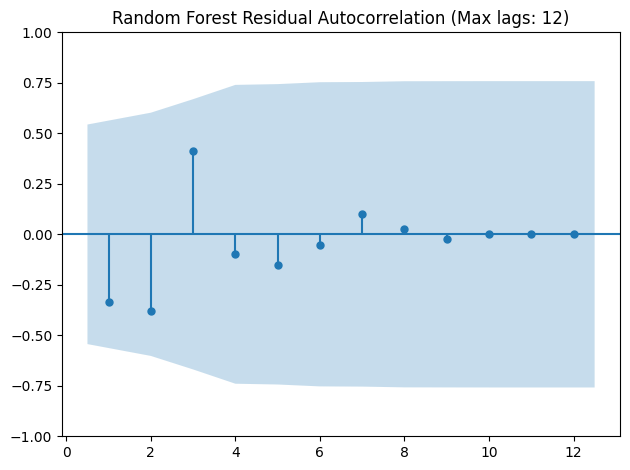


 SVR Performance Metrics:
   RMSE  : 0.2594
   MAPE  : 8703404054780798.00%
   R²    : -0.1693
   MAE   : 0.1729


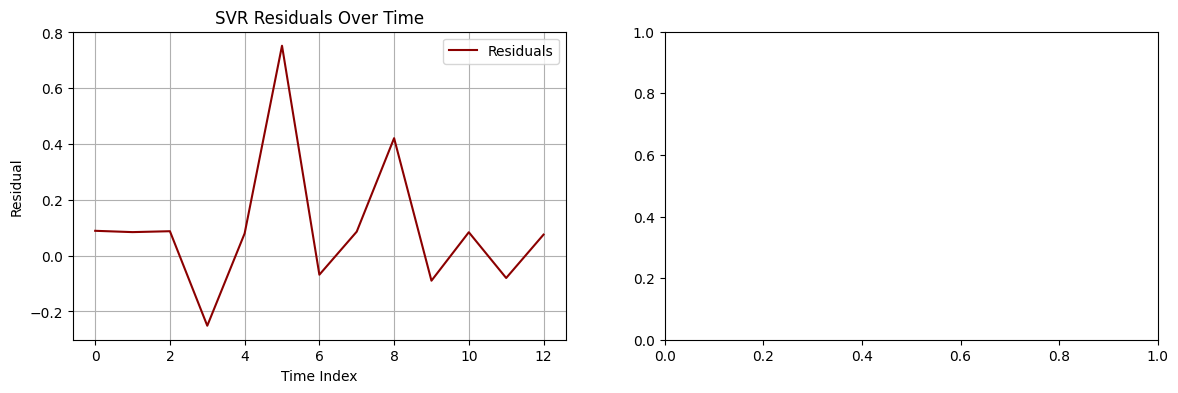

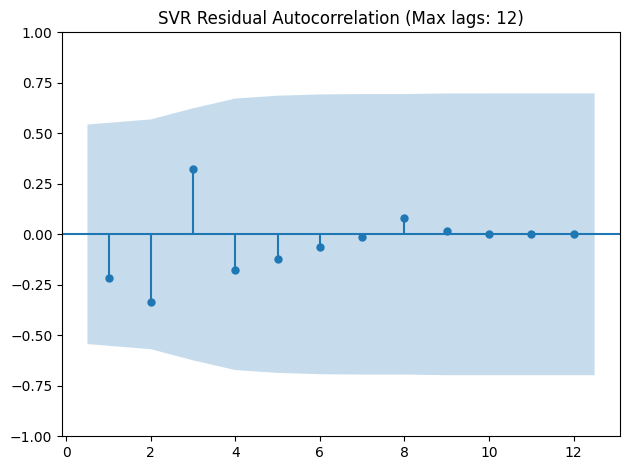


 KNN Performance Metrics:
   RMSE  : 0.2366
   MAPE  : 10777845262083268.00%
   R²    : 0.0265
   MAE   : 0.1496


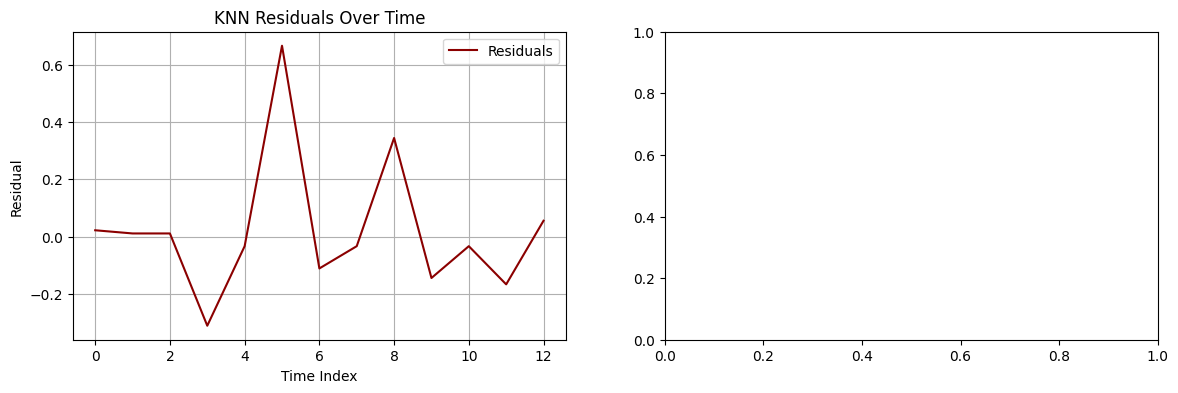

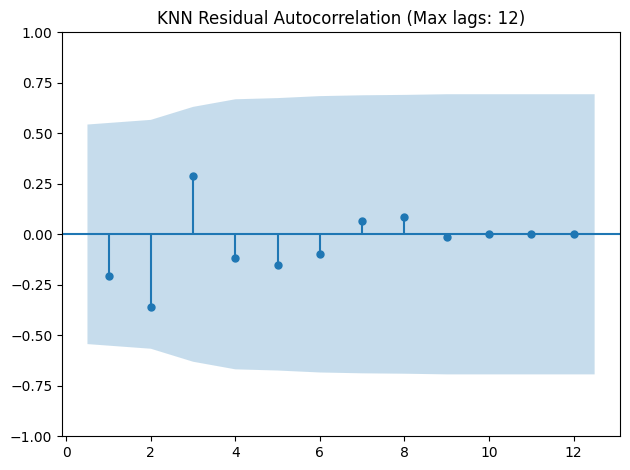


 RNN Performance Metrics:
   RMSE  : 0.2436
   MAPE  : 11430967700558800.00%
   R²    : -0.0319
   MAE   : 0.1497


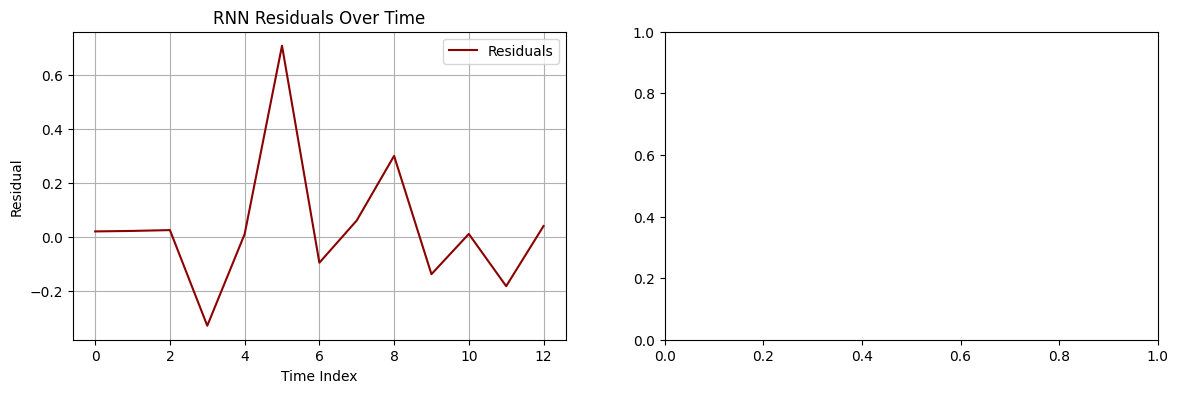

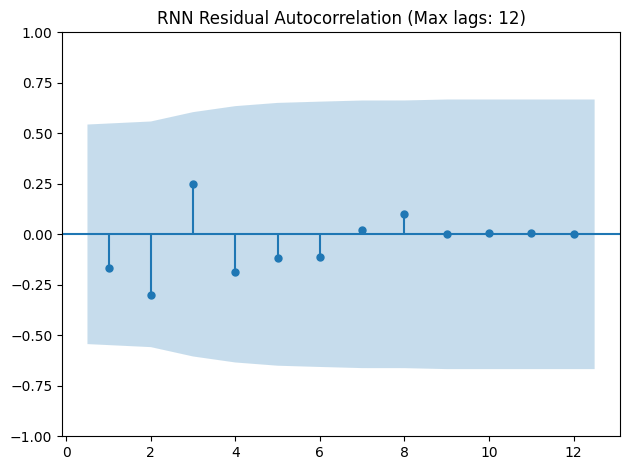


 CNN Performance Metrics:
   RMSE  : 0.2537
   MAPE  : 10357868056765090.00%
   R²    : -0.1188
   MAE   : 0.1720


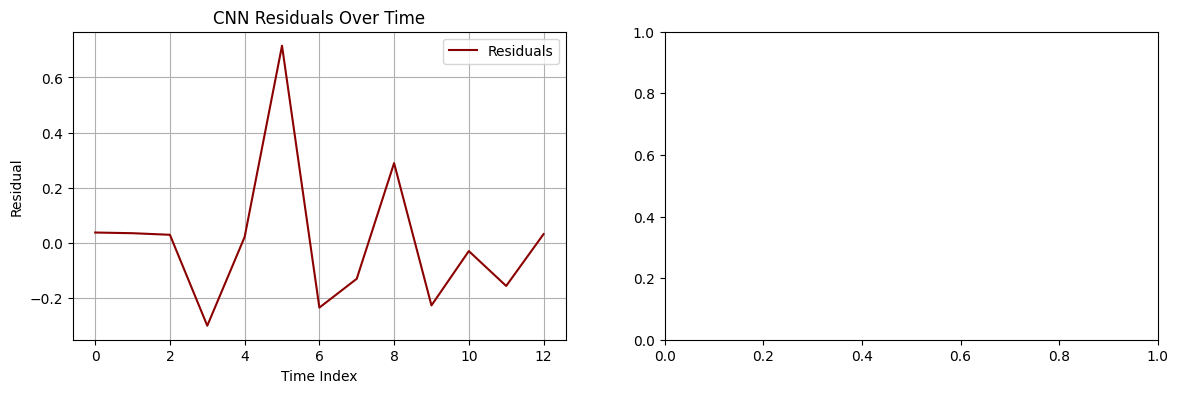

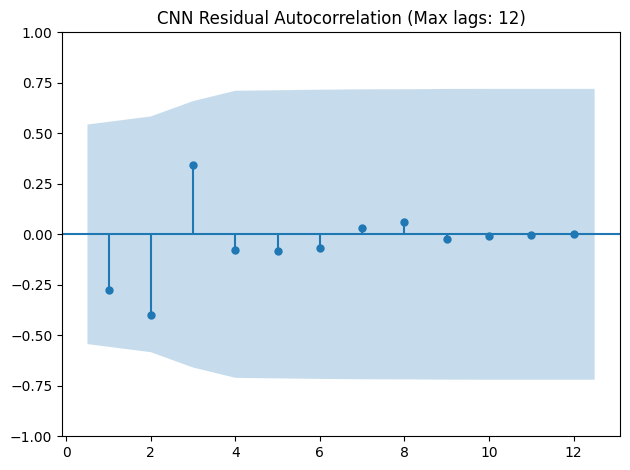

In [35]:
# ENHANCED EVALUATION & RESIDUAL ACF ANALYSIS 

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf

def evaluate_with_residuals(model_name, y_test, y_pred):
    """
    Print enhanced evaluation metrics and plot residuals & ACF.

    Args:
        model_name (str): Name of the model.
        y_test (np.array): Actual values.
        y_pred (np.array): Predicted values.
    """

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n {model_name} Performance Metrics:")
    print(f"   RMSE  : {rmse:.4f}")
    print(f"   MAPE  : {mape:.2%}")
    print(f"   R²    : {r2:.4f}")
    print(f"   MAE   : {mae:.4f}")

    # Residuals
    residuals = y_test - y_pred

    # Determine max lags allowed based on residual length
    max_lags = min(20, len(residuals) - 1)

    # Plot residuals over time
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(residuals, label="Residuals", color="darkred")
    plt.title(f"{model_name} Residuals Over Time")
    plt.xlabel("Time Index")
    plt.ylabel("Residual")
    plt.grid(True)
    plt.legend()

    # Plot ACF safely
    plt.subplot(1, 2, 2)
    plot_acf(residuals, lags=max_lags, zero=False)
    plt.title(f"{model_name} Residual Autocorrelation (Max lags: {max_lags})")
    plt.tight_layout()
    plt.show()

# Run evaluation safely
evaluate_with_residuals("XGBoost", y_test, xgb_preds)
evaluate_with_residuals("Random Forest", y_test, rf_preds)
evaluate_with_residuals("SVR", y_test, svr_preds)
evaluate_with_residuals("KNN", y_test, knn_preds)

# Optional: if DL models are available
evaluate_with_residuals("RNN", y_test, rnn_preds)
evaluate_with_residuals("CNN", y_test, cnn_preds)



 No critical risk detected. Predicted: 1.8, Threshold: 2.1


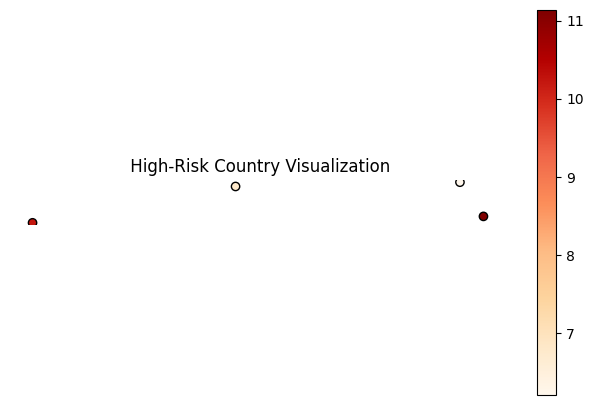

In [36]:
# STEP 14: MITIGATION STRATEGY & RISK MAPPING

import geopandas as gpd
from shapely.geometry import Point

def mitigation_strategy(predicted_attacks, actual_attacks, model_name="CNN"):
    """
    Triggers alert if predicted attacks exceed threshold and shows a risk map.
    
    Args:
        predicted_attacks (float): Model-predicted value (original scale).
        actual_attacks (float): True observed value (original scale).
        model_name (str): The model name used for the prediction.
        
    Paper Reference: Section 4, Fig. 5 (Power BI-style visualization)
    """
    # Calculate threshold: mean + 2σ
    values = [predicted_attacks, actual_attacks]
    threshold = np.mean(values) + 2 * np.std(values)
    
    # Trigger mitigation alert
    if predicted_attacks > threshold:
        print(f"\n ALERT: {predicted_attacks:.1f} attacks predicted by {model_name} (Threshold: {threshold:.1f})")
        print(" Mitigation: Enable rate-limiting & geo-blocking for suspicious regions.")
    else:
        print(f"\n No critical risk detected. Predicted: {predicted_attacks:.1f}, Threshold: {threshold:.1f}")
    
    # Dummy country-level attack data (can later use real aggregation if desired)
    attack_data = {
        "country": ["US", "UK", "RU", "CN"],
        "predicted_risk": np.random.uniform(5, 15, 4)  # Simulated example
    }

    # Assign rough coordinates for demonstration purposes
    geometry = [
        Point(-95, 37),  # US
        Point(0, 54),    # UK
        Point(105, 56),  # RU
        Point(116, 40),  # CN
    ]
    
    gdf = gpd.GeoDataFrame(attack_data, geometry=geometry)
    
    # Plot heatmap
    gdf.plot(column="predicted_risk", cmap="OrRd", legend=True, edgecolor="black", figsize=(8, 5))
    plt.title(" High-Risk Country Visualization")
    plt.axis("off")
    plt.show()

# Example usage: Convert back from scaled to original using scaler_y
predicted_scaled = cnn_preds[-1]  # Or any best model's last prediction
actual_scaled = y_test[-1]

predicted_orig = scaler_y.inverse_transform([[predicted_scaled]])[0][0]
actual_orig = scaler_y.inverse_transform([[actual_scaled]])[0][0]

# Call mitigation function
mitigation_strategy(predicted_orig, actual_orig, model_name="CNN")


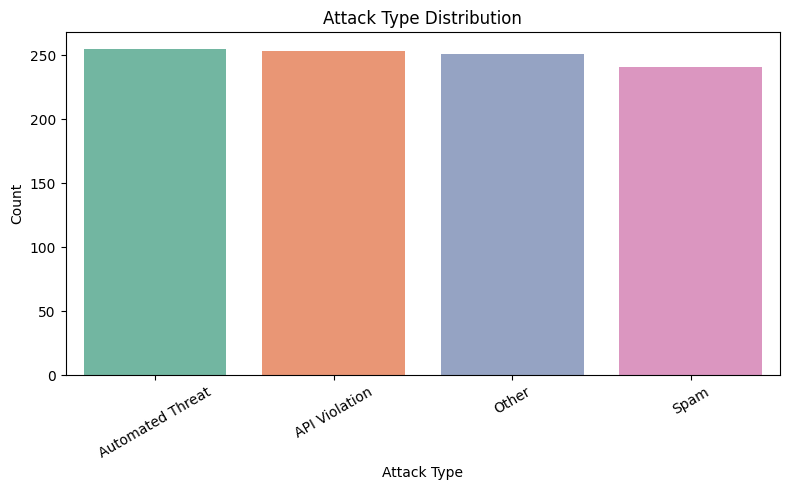

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data (adjust the path if needed)
df = pd.read_csv('cyber_data.csv')

# --- 1. Barplot: Attack Type Counts ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='attack_type', order=df['attack_type'].value_counts().index, palette='Set2')
plt.title("Attack Type Distribution")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()



In [42]:
#  NON-TECHNICAL PDF SUMMARY REPORT

from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from datetime import datetime

def generate_pdf_report(model_name, predicted, actual, sector="Finance", country="UK", confidence="90%"):
    """
    Generates a non-technical summary report in PDF format.
    
    Args:
        model_name (str): Model used for prediction.
        predicted (float): Predicted attack count (original scale).
        actual (float): Actual attack count (original scale).
        sector (str): Affected industry sector.
        country (str): Country of concern.
        confidence (str): Confidence level (optional).
        
    Paper Reference: Section 4, Fig. 8 & 9
    """

    file_name = f"cyber_risk_report_{datetime.now().strftime('%Y%m%d_%H%M')}.pdf"
    c = canvas.Canvas(file_name, pagesize=letter)
    width, height = letter

    # Header
    c.setFont("Helvetica-Bold", 16)
    c.drawString(50, height - 50, f"Cyber Threat Prediction Report")

    # Sub-header
    c.setFont("Helvetica", 12)
    summary = (f"Model: {model_name}\n"
               f"Predicted Attacks (next 15 mins): {predicted:.1f}\n"
               f"Actual Observed: {actual:.1f}\n"
               f"Risk Level: ")

    # Determine risk level
    risk_level = "LOW"
    if predicted > actual * 1.5:
        risk_level = "HIGH"
    elif predicted > actual * 1.1:
        risk_level = "MODERATE"
    summary += risk_level

    # Write summary
    y = height - 80
    for line in summary.split('\n'):
        c.drawString(50, y, line)
        y -= 20

    # Add recommendation
    mitigation = f"Recommended Action: Block IPs targeting {sector} sector in {country}.\n"
    mitigation += "Enable API rate limiting and monitor logs for suspicious activity."
    for line in mitigation.split('\n'):
        c.drawString(50, y, line)
        y -= 20

    # Footer and timestamp
    c.setFont("Helvetica-Oblique", 10)
    c.drawString(50, 50, f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    c.save()
    print(f" PDF report generated: {file_name}")


In [43]:
# Convert from scaled to original (if needed)
pred_orig = scaler_y.inverse_transform([[cnn_preds[-1]]])[0][0]
act_orig = scaler_y.inverse_transform([[y_test[-1]]])[0][0]

# Generate the report
generate_pdf_report("CNN", pred_orig, act_orig, sector="Banking", country="UK")


 PDF report generated: cyber_risk_report_20250520_0434.pdf


In [ ]:
mape, attacks def, network resilience,min max scalar,libraries-sklearn, xgboost, pandas, numpy, tensorflow, matplotlib